In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Hyejeong

/content/drive/MyDrive/Hyejeong


In [ ]:
! python -m pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
import sys
sys.path.insert(0, 'pytorch-openpose/')
import cv2
from src import model
from src import util
from src.body import Body
from src.hand import Hand
import matplotlib.pyplot as plt
import copy
import numpy as np
import os.path
import pandas as pd


class OpenPose():
    def __init__(self,modelpath):  
        self.body_estimation=Body(modelpath+'/body_pose_model.pth')
        self.hand_estimation = Hand(modelpath+'/hand_pose_model.pth')

    def handpt(self, oriImg):    
        candidate, subset = self.body_estimation(oriImg)
        canvas = copy.deepcopy(oriImg)
        canvas = util.draw_bodypose(canvas, candidate, subset)

        hands_list = util.handDetect(candidate, subset, oriImg)
        all_hand_peaks = []
        cnt=0
        
        for x, y, w, is_left in hands_list:
            peaks = self.hand_estimation(oriImg[y:y+w, x:x+w, :])
            peaks[:, 0] = np.where(peaks[:, 0]==0, peaks[:, 0], peaks[:, 0]+x)
            peaks[:, 1] = np.where(peaks[:, 1]==0, peaks[:, 1], peaks[:, 1]+y)

            all_hand_peaks.append(peaks)

        canvas = util.draw_handpose(canvas, all_hand_peaks)
        plt.imshow(canvas[:, :, [2, 1, 0]])
        plt.axis('off')
        plt.show()

        return all_hand_peaks

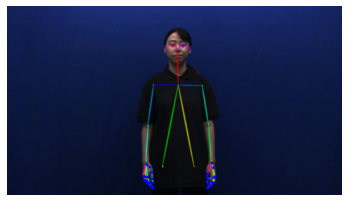

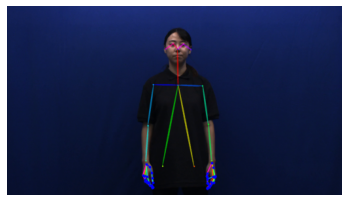

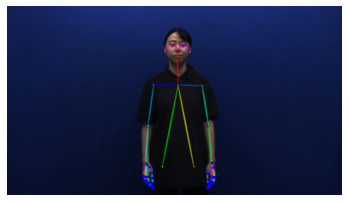

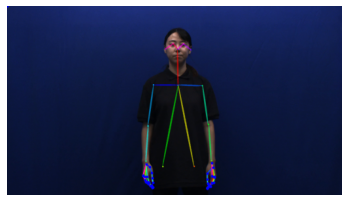

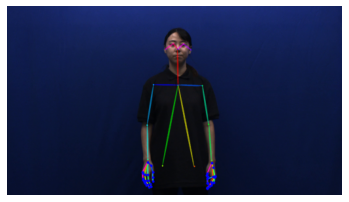

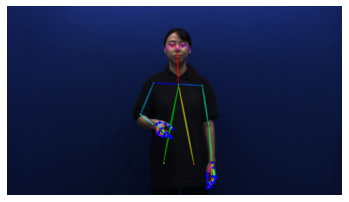

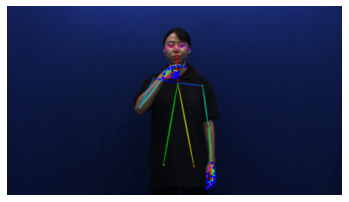

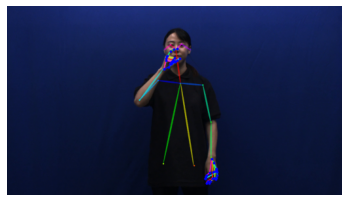

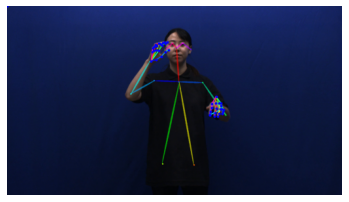

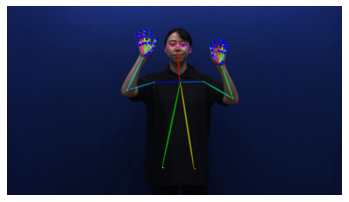

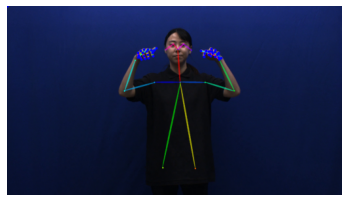

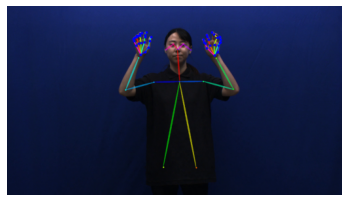

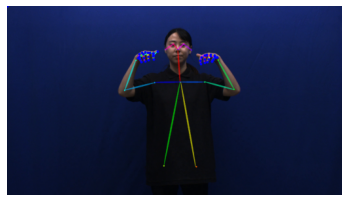

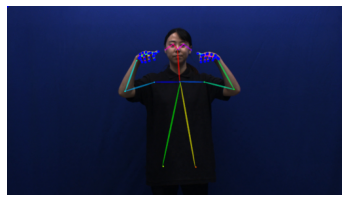

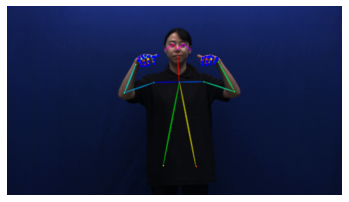

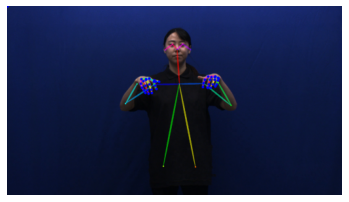

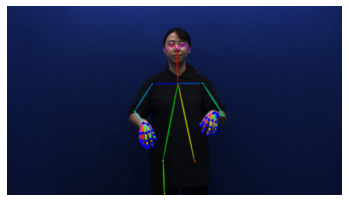

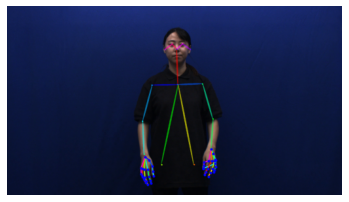

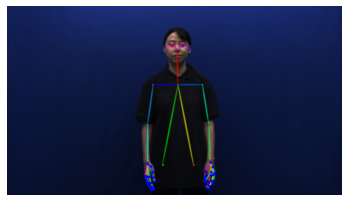

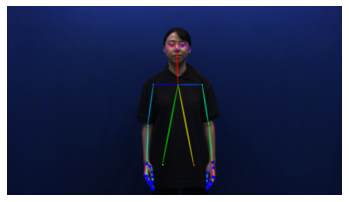

1/1 [==============================] - 1s 1s/step
Label:  4
Translation:  비


In [ ]:
if __name__ == "__main__":
    flist=list()
    modelpt='pytorch-openpose/model'
    pose=OpenPose(modelpt)
    arr = []
    temp_peaks = [] #이전 frame의 keypoint
    
    vidcap = cv2.VideoCapture('NIA_SL_WORD2552_REAL17_F.mp4')
    count = 0

    while(vidcap.isOpened()):
        ret, image = vidcap.read()
        if not ret:
          break

        #영상 길이에 따라 이미지 추출 간격 조절
        total_frame_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
        frame = int(total_frame_count/20)

        # frame 당 하나씩 이미지 추출
        if(int(vidcap.get(1)) % frame == 0 and count < 20):
          position = pose.handpt(image)
          # shape 수정, 1차원으로 만들기(0:84)
          out_arr = np.ravel(position, order='C')

          if out_arr.size == 44:
            out_arr = temp_peaks.reshape(1, 84)
          if out_arr.size == 84:
            temp_peaks = out_arr
            out_arr = out_arr.reshape(1, 84)
          
          # 뒤에 append
          arr = np.append(arr, out_arr)
          count += 1

    #print(arr)
    vidcap.release()

from sklearn.preprocessing import Normalizer
import tensorflow as tf

X = arr.reshape(1,1680)
transformer = Normalizer().fit(X)
X = transformer.transform(X)

model = tf.keras.models.load_model('BLSTM.h5')
y_predict = model.predict(X)
label = y_predict[0].argmax()

CLASSES = ["춥다", "덥다", "먹구름", "바람", "비", "온도", "장마", "햇빛", "정말", "좋다"]
print('Label: ', label)
print('Translation: ', CLASSES[label])

In [ ]:
import cv2
from IPython.display import HTML, display, Javascript
from base64 import b64encode

def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

video_path = 'NIA_SL_WORD2552_REAL17_F.mp4'
print('Motion: ', CLASSES[label])
show_video(video_path)

Output hidden; open in https://colab.research.google.com to view.